(uncomment the cell below to install dependencies)

In [1]:
# !pip install delta-spark==2.4.0 prefect names

# Homework 08 (Prefect)

## Radosław Jurczak

-------------------------------------------------

A docker network `de_network` is used, created by
```{bash}
docker network create de_network
```

Minio was run with the following command:
```{bash}
docker run -p 9000:9000 -p 9090:9090 --name minio --network=de_network -v ~/minio/data:/data -e "MINIO_ROOT_USER=admin" -e "MINIO_ROOT_PASSWORD=adminadmin" quay.io/minio/minio server /data --console-address ":9090"
```

To succesfully run the code below, you'll need to create a minio bucket called `hw8`.

The notebook was run inside docker, set up by
```{bash}
docker run  \
    -it -d --rm \
    --name de-course \
    --network=de_network \
    -p 10000:8888 -p 4041:4040  -p 4200:4200\
    -v "${PWD}":/home/jovyan/work \
    jupyter/all-spark-notebook:spark-3.4.0
```

Prefect was run by the following command (from a terminal inside jupyter):
```{bash}
prefect server start --host 0.0.0.0
```

In [2]:
import random

import names
import prefect
from prefect.runtime import flow_run, task_run
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import StringType
from tqdm import tqdm

#### SP1: generate a synthetic dataset of user account balance (`user_id`, `balance`, `change`, 50 000 data points) and store it in Minio

In [3]:
@prefect.task
def get_balance_df(spark):
    users_aux = [f"user_id_{i}" for i in range(10_000-1)]
    balance = [
        (random.choice(users_aux),
         round(random.uniform(1, 50_000)),
         round(random.uniform(-5_000, 5_000)))
        for i in range(50_000-1)
    ]
    balance_df = spark.createDataFrame(
        balance,
        ["user_id", "balance", "change"]
    )
    minio_location = "s3a://hw8/users-balance/"
    balance_df.write.format("parquet").mode("overwrite").save(minio_location)
    return minio_location

#### SP2: generate a user dataset (`user_id`, `user_name`) that will be used as reference for the first; store the dataset in Minio

In [4]:
@prefect.task
def get_users_df(spark):
    
    users = [
        (f"user_id_{i}",
         names.get_full_name())
        for i in range(5_000-1)
    ]
    users_df = spark.createDataFrame(
        users,
        ["user_id", "user_name"]
    )
    minio_location = "s3a://hw8/users/"
    users_df.write.format("parquet").mode("overwrite").save(minio_location)
    return minio_location

#### SP3: join two previous datasets, resulting in a third dataset:
 - `user_id`
 - `user_name`
 - `max_balance` -- largest account balance of the given user
 - `min_balance` -- smallest account balance of the given user
 - `largest_change` -- most significant balance change of the given user (keeping the sign)
 - `money_total` -- total current amount of money of the given user (i.e. first recorded balance plus the sum of all recorded changes)

In [5]:
@prefect.task
def get_full_users_df(spark, balance_df_path, users_df_path):
    balance_df = spark.read.load(balance_df_path)
    users_df = spark.read.load(users_df_path)
    full_df = balance_df.join(
        users_df, ["user_id"], "left"
    ).groupby(
        f.col("user_id")
    ).agg(
        f.first("user_name").alias("user_name"),
        f.max("balance").alias("max_balance"),
        f.min("balance").alias("min_balance"),
        f.when(f.max("change") == f.max(f.abs("change")), f.max("change")).otherwise(f.min("change")).alias("largest_change"),
        (f.first("balance") + f.sum("change")).alias("current_balance")
    ).orderBy(
        f.col("user_id")
    )
    minio_location = "s3a://hw8/full-users/"
    full_df.write.format("parquet").mode("overwrite").save(minio_location)
    return minio_location

#### Spark pipeline 4: display to console top N users with largest account balance, using the dataset generated by pipeline 3

In [6]:
@prefect.task
def show_top_n(spark, full_df_path, n):
    full_df = spark.read.load(full_df_path)
    return print(full_df.orderBy(f.col("current_balance").desc()).show(n))

In [7]:
@prefect.flow(name="homework-8")
def data_pipeline():
    spark_conf = (
    SparkConf()
    .set("spark.jars.packages", 'org.apache.hadoop:hadoop-client:3.3.4,org.apache.hadoop:hadoop-aws:3.3.4')
    .set("spark.driver.memory", "6g")
    .set("spark.hadoop.fs.s3a.endpoint", "minio:9000")
    .set("spark.hadoop.fs.s3a.access.key", "admin")
    .set("spark.hadoop.fs.s3a.secret.key", "adminadmin" )
    .set("spark.hadoop.fs.s3a.path.style.access", "true") 
    .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
    .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")).setAppName("AsdfPipeline")
    sc = SparkContext.getOrCreate(spark_conf)
    spark = SparkSession(sc)
    
    balance_df_path = get_balance_df(spark)
    users_df_path = get_users_df(spark)
    full_df_path = get_full_users_df(spark, balance_df_path, users_df_path)
    N = 10
    show_top_n(spark, full_df_path, N)

In [8]:
data_pipeline()

01:18:26.186 | INFO    | prefect.engine - Created flow run 'cherry-skua' for flow 'homework-8'

01:18:33.650 | INFO    | Flow run 'cherry-skua' - Created task run 'get_balance_df-0' for task 'get_balance_df'

01:18:33.652 | INFO    | Flow run 'cherry-skua' - Executing 'get_balance_df-0' immediately...

01:18:40.599 | INFO    | Task run 'get_balance_df-0' - Finished in state Completed()

01:18:40.623 | INFO    | Flow run 'cherry-skua' - Created task run 'get_users_df-0' for task 'get_users_df'

01:18:40.625 | INFO    | Flow run 'cherry-skua' - Executing 'get_users_df-0' immediately...

01:18:53.209 | INFO    | Task run 'get_users_df-0' - Finished in state Completed()

01:18:53.241 | INFO    | Flow run 'cherry-skua' - Created task run 'get_full_users_df-0' for task 'get_full_users_df'

01:18:53.244 | INFO    | Flow run 'cherry-skua' - Executing 'get_full_users_df-0' immediately...

01:18:56.407 | INFO    | Task run 'get_full_users_df-0' - Finished in state Completed()

01:18:56.439 | INFO    | Flow run 'cherry-skua' - Created task run 'show_top_n-0' for task 'show_top_n'

01:18:56.441 | INFO    | Flow run 'cherry-skua' - Executing 'show_top_n-0' immediately...

+------------+----------------+-----------+-----------+--------------+---------------+
|     user_id|       user_name|max_balance|min_balance|largest_change|current_balance|
+------------+----------------+-----------+-----------+--------------+---------------+
|user_id_3555|     Mary Dorado|      49245|       1607|          4361|          71843|
| user_id_499|    Paul Koehler|      48070|      14316|          4286|          70156|
|user_id_2565|   Rachel Gordon|      47105|       9296|          4974|          69593|
|user_id_2368|     Emily Reihl|      49646|       1013|          4620|          68121|
| user_id_954|    Jose Cabrera|      49729|       1007|          4983|          68018|
|user_id_1706|Robert Robertson|      49332|        776|          4688|          67875|
|user_id_9923|            null|      44902|       2682|          4769|          67825|
|  user_id_46|     Jeff Castro|      48124|       7567|          4510|          67583|
|user_id_4557|      Ruth Woods|      48426|

01:18:56.902 | INFO    | Task run 'show_top_n-0' - Finished in state Completed()

01:18:56.942 | INFO    | Flow run 'cherry-skua' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `str`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `str`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `str`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`'))]

#### A screenshot from Prefect UI after successful pipeline execution:

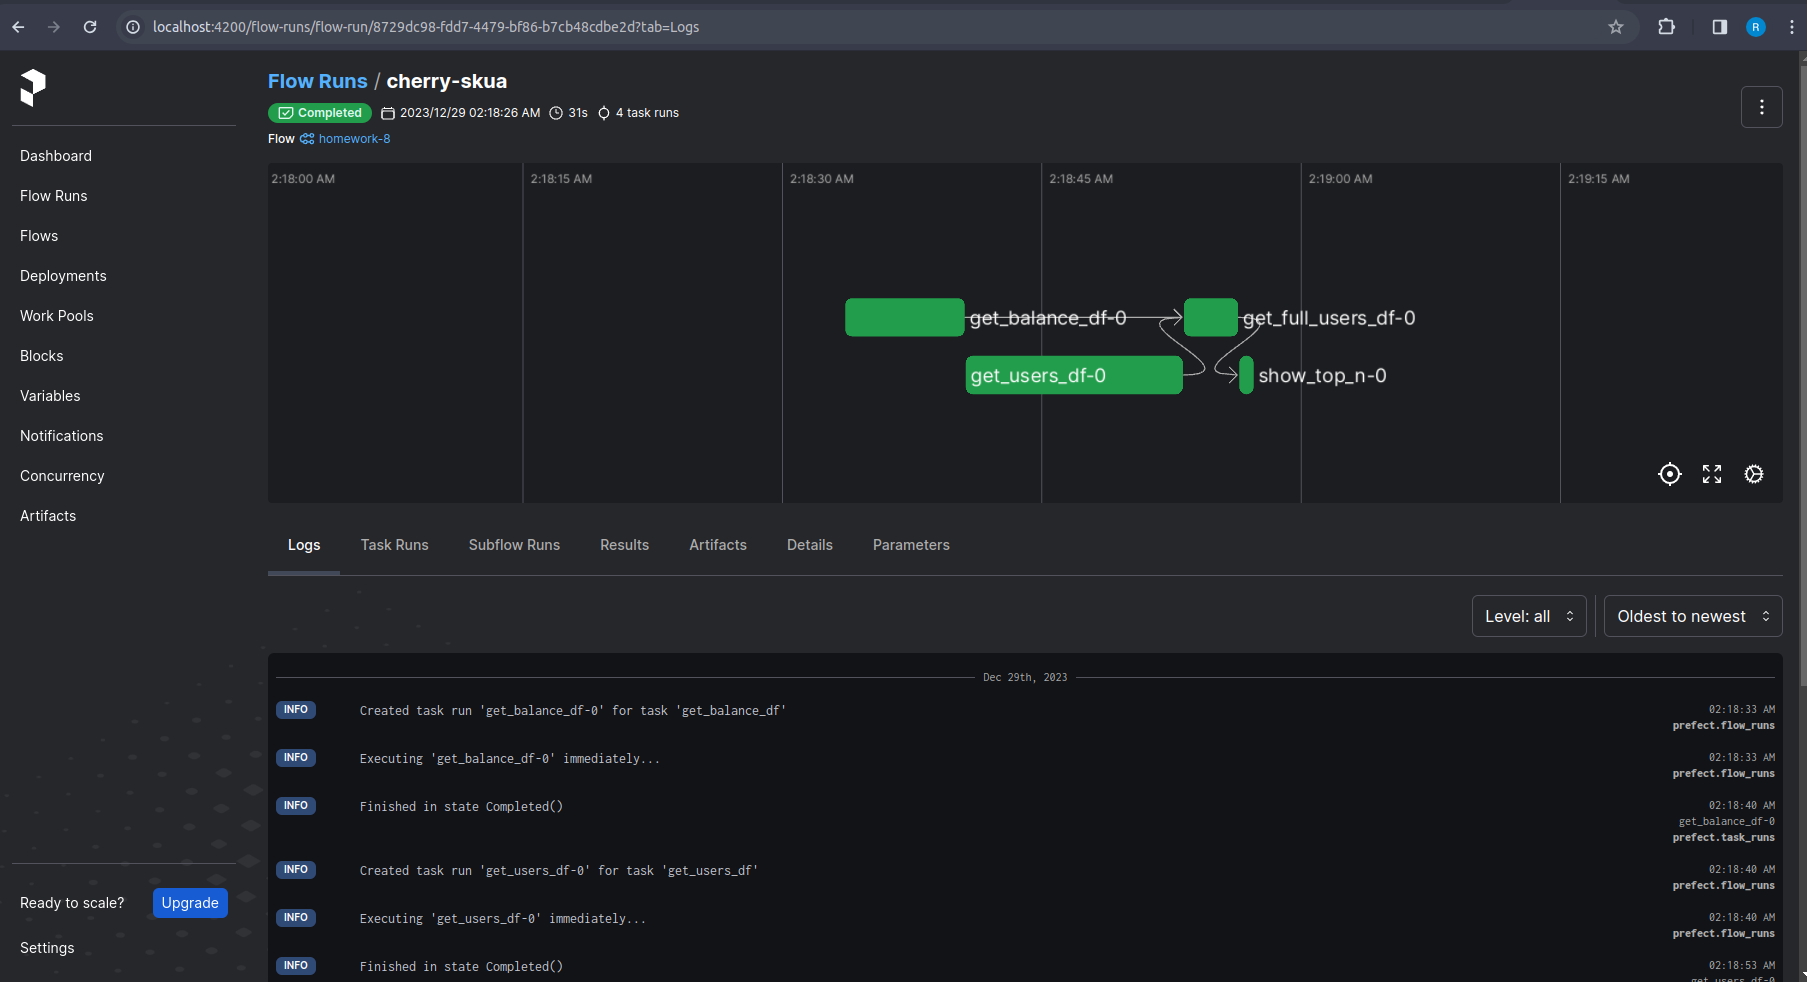